<a href="https://colab.research.google.com/github/ArlexMR/ECE-614-DeepLearning/blob/main/.../Lab3/ECE614_Lab3_Notebook_ArlexMarin_JohnMoore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 614 - DEEP LEARNING
## SPRING 2023
## LABORATORY 3
## JOHN MOORE and ARLEX MARIN

All figures in this notebook can be recreated using the models saved in the folder `SavedModels`.  
The code for loading the files is in the cells titled `Load in Pickle Files for Each Model`  


##Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Sequential, Model
from keras import regularizers
from keras.regularizers import l1, l2
import pandas as pd
from tensorflow import keras
from keras.layers.core import Dense, Dropout
from keras.datasets import cifar10
from keras import optimizers
import plotly.graph_objects as go
import itertools
from google.colab import drive
import os
import pickle



##Functions

In [ ]:
def plot_sample_images(X, y, images_per_class, gridspec_kw):
  fig, axs = plt.subplots(10, images_per_class, figsize = (12,18), gridspec_kw = gridspec_kw )

  axs = axs.flatten()
  ax_idx = 0
  
  for class_ in range(10):

    all_indices = np.flatnonzero(y == class_)
    rand_sampl  = np.random.choice(all_indices, size = images_per_class, replace = False)
    ax = axs[ax_idx]
    ax.annotate(f"{class_}: {class_names[class_]}" , xy = (-0.05,0.5), xycoords = "axes fraction", ha = "right", va = "center", fontsize = 14)

    for sample_idx in rand_sampl:
        ax = axs[ax_idx] 
        ax.imshow(X[sample_idx], cmap = "gray")
        ax.set_xticks([])
        ax.set_yticks([])

        ax_idx += 1

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def to_categorical(arr, num_classes):
  return np.eye(num_classes)[arr.flatten()]  

def get_task1_model():

  model = Sequential()
  model.add(keras.Input(shape=(1024,)))  # Input Layer
  
  model.add(Dense(32, activation = "relu" ,name = "BottleNeck"))  # Bottleneck Layer
  model.add(Dense(1024, activation = "sigmoid", name = "Output")) # Output Layer

  model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ["accuracy"])
  model.summary()

  return model

# Plot Loss Graph
def plot_loss_graph(history):
  plt.figure()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss'); plt.xlabel('Epoch')
  plt.legend(('Train','Validation'))
  plt.show()

# Plot Accuracy Graph
def plot_acc_graph(history):
  plt.figure()
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy'); plt.xlabel('Epoch')
  plt.legend(('Train','Validation'))
  plt.show()

def get_task2_model(bottleneck_size,hidden_activation,learning_rate, optimizer, regularizer = None):
 

  model = Sequential()

  # Input Layer
  model.add(keras.Input(shape=(1024,)))

  # Add bottleneck
  model.add(Dense(bottleneck_size, 
                      activation          = hidden_activation, 
                      kernel_regularizer  = regularizer, 
                      name                = "Compression"
                )     
          )
  
  # Output
  model.add(Dense(1024, activation = "sigmoid", name = "Output")) 


  model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ["accuracy"])
  model.summary()
  return model

##Prepare Data

In [ ]:
# Original RGB Images
(x_train_c, y_train), (x_test_c, y_test) = cifar10.load_data() 

class_names = {0: "Airplane",
               1: "Automobile",
               2: "Bird",
               3: "Cat",
               4: "Deer",
               5: "Dog",
               6: "Frog",
               7: "Horse",
               8: "Ship",
               9: "Truck"
               }

# Non-Noisy Grayscale Images
x_train_g   = rgb2gray(x_train_c)
x_train_g   = x_train_g.astype('float32')/255
x_test_g    = rgb2gray(x_test_c)
x_test_g    = x_test_g.astype('float32')/255

# Noisy Grayscale Images
x_train_noisy = x_train_g + 0.05 * np.random.normal(loc=0, scale = 1., size=x_train_g.shape)
x_test_noisy = x_test_g + 0.05 * np.random.normal(loc=0, scale = 1., size=x_test_g.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

170498071/170498071 [==============================] - 5s 0us/step


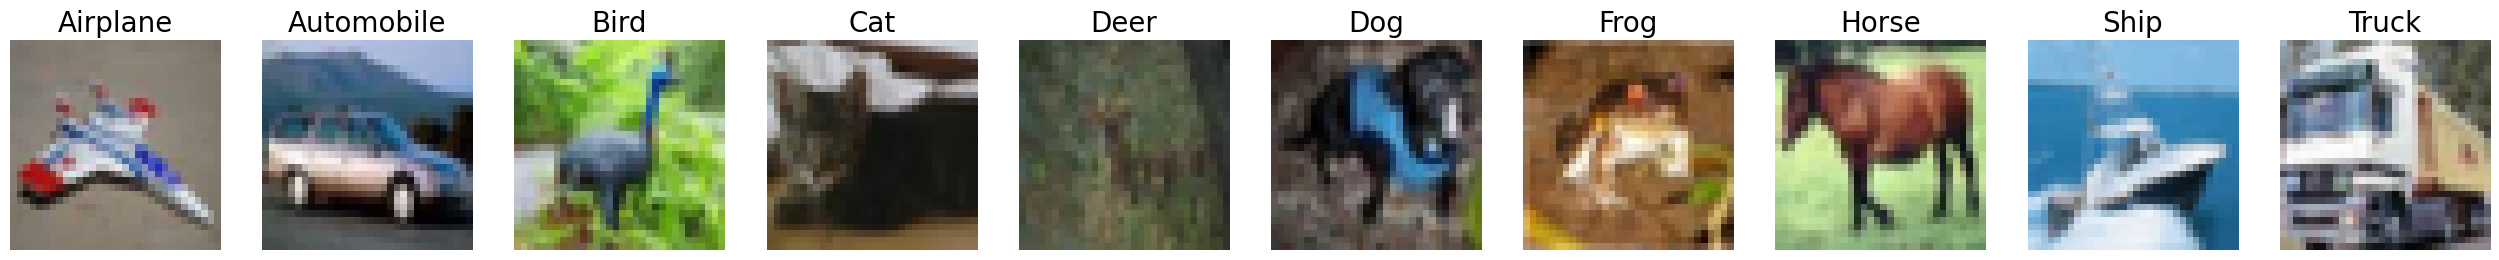

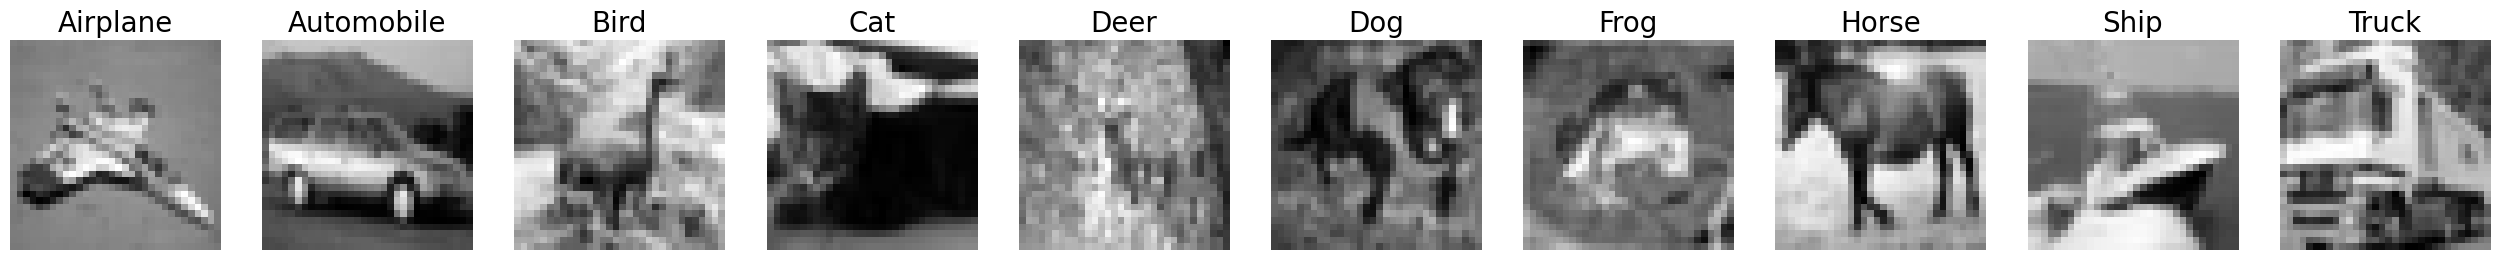

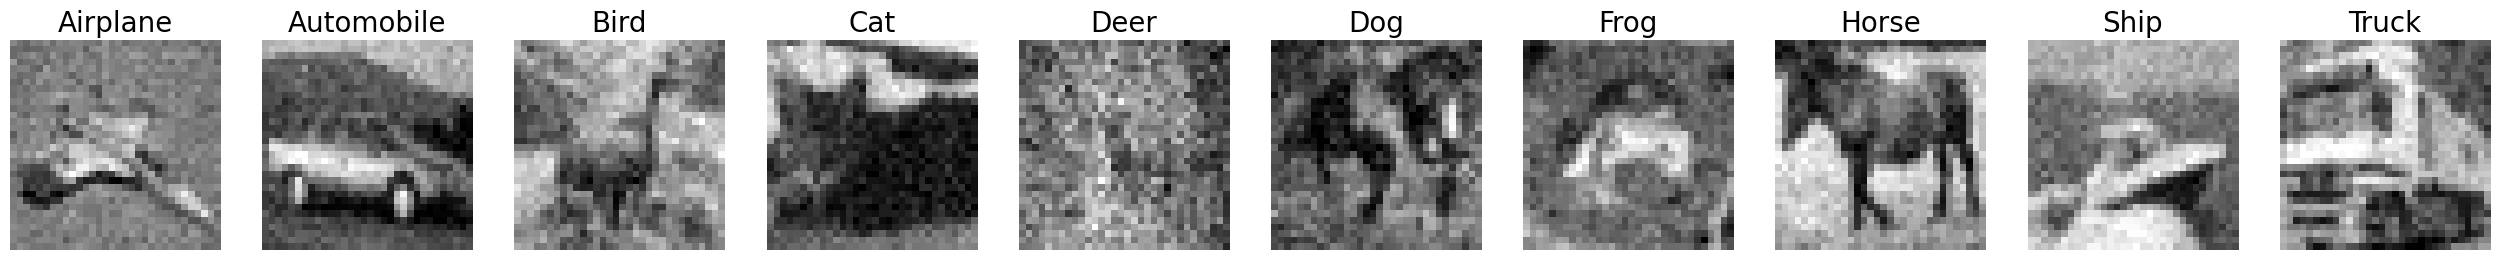

In [ ]:
#@title Sample Images
# RGB Images
f, axarr = plt.subplots(nrows=1, ncols=10, figsize=[32,32])
axarr[0].imshow(x_train_c[30]) # airplane 
axarr[1].imshow(x_train_c[4]) # automobile
axarr[2].imshow(x_train_c[6]) # bird
axarr[3].imshow(x_train_c[9]) # cat
axarr[4].imshow(x_train_c[10]) # deer
axarr[5].imshow(x_train_c[27]) # dog 
axarr[6].imshow(x_train_c[0]) # frog
axarr[7].imshow(x_train_c[7]) # horse
axarr[8].imshow(x_train_c[8]) # ship
axarr[9].imshow(x_train_c[1]) # truck
for i in range(10):
    axarr[i].axis('off')
cols = ['Airplane','Automobile','Bird','Cat','Deer','Dog','Frog','Horse','Ship','Truck']
for t in range(10):
    axarr[t].set_title(cols[t], fontsize=20)

# Non-Noisy Grayscale Images
f, axarr = plt.subplots(nrows=1, ncols=10, figsize=[32,32])
axarr[0].imshow(x_train_g[30],cmap='gray') # airplane 
axarr[1].imshow(x_train_g[4],cmap='gray') # automobile
axarr[2].imshow(x_train_g[6],cmap='gray') # bird
axarr[3].imshow(x_train_g[9],cmap='gray') # cat
axarr[4].imshow(x_train_g[10],cmap='gray') # deer
axarr[5].imshow(x_train_g[27],cmap='gray') # dog 
axarr[6].imshow(x_train_g[0],cmap='gray') # frog
axarr[7].imshow(x_train_g[7],cmap='gray') # horse
axarr[8].imshow(x_train_g[8],cmap='gray') # ship
axarr[9].imshow(x_train_g[1],cmap='gray') # truck
#Turn off axes
for j in range(10):
  axarr[j].axis('off')
for t in range(10):
    axarr[t].set_title(cols[t], fontsize=20)

# Noisy Grayscale Images
f, axarr = plt.subplots(nrows=1, ncols=10, figsize=[32,32])
axarr[0].imshow(x_train_noisy[30],cmap='gray') # airplane 
axarr[1].imshow(x_train_noisy[4],cmap='gray') # automobile
axarr[2].imshow(x_train_noisy[6],cmap='gray') # bird
axarr[3].imshow(x_train_noisy[9],cmap='gray') # cat
axarr[4].imshow(x_train_noisy[10],cmap='gray') # deer
axarr[5].imshow(x_train_noisy[27],cmap='gray') # dog 
axarr[6].imshow(x_train_noisy[0],cmap='gray') # frog
axarr[7].imshow(x_train_noisy[7],cmap='gray') # horse
axarr[8].imshow(x_train_noisy[8],cmap='gray') # ship
axarr[9].imshow(x_train_noisy[1],cmap='gray') # truck
#Turn off axes
for j in range(10):
  axarr[j].axis('off')
for t in range(10):
    axarr[t].set_title(cols[t], fontsize=20)

## Task 1:
Using the grayscale images as the training and the target values, train a simple model of two layers as in Task 1 in the Lab 3 Intro

In [ ]:
#@title Simple Model Training
x_train_g = x_train_g.reshape(50000, 1024)
x_test_g = x_test_g.reshape(10000, 1024)
model = get_task1_model()
training_samples = 50000
testing_samples  = 10000

batch_size = 128
epochs     = 10

history = model.fit(x_train_g[:training_samples],
                    x_train_g[:training_samples],
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=(x_test_g[:testing_samples],x_test_g[:testing_samples]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 BottleNeck (Dense)          (None, 32)                32800     
                                                                 
 Output (Dense)              (None, 1024)              33792     
                                                                 
Total params: 66,592
Trainable params: 66,592
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
391/391 [==============================] - 7s 14ms/step - loss: 0.6432 - accuracy: 0.0040 - val_loss: 0.6248 - val_accuracy: 0.0062
Epoch 2/10
391/391 [==============================] - 7s 18ms/step - loss: 0.6165 - accuracy: 0.0074 - val_loss: 0.6095 - val_accuracy: 0.0085
Epoch 3/10
391/391 [==============================] - 5s 13ms/step - loss: 0.6049 - accuracy: 0.0086 - val_loss: 0.6028 - val_accuracy: 0.0104
Epoch 4/10
391/391 

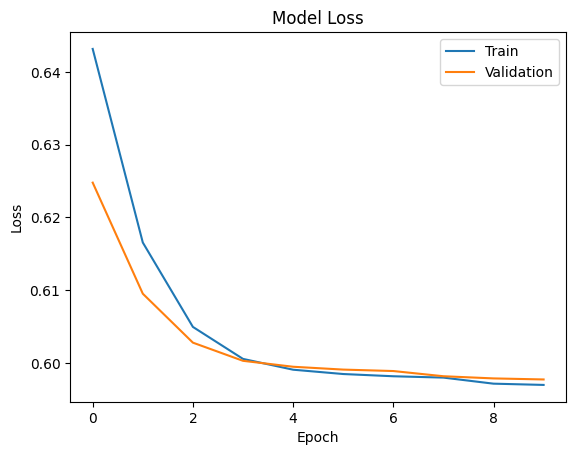

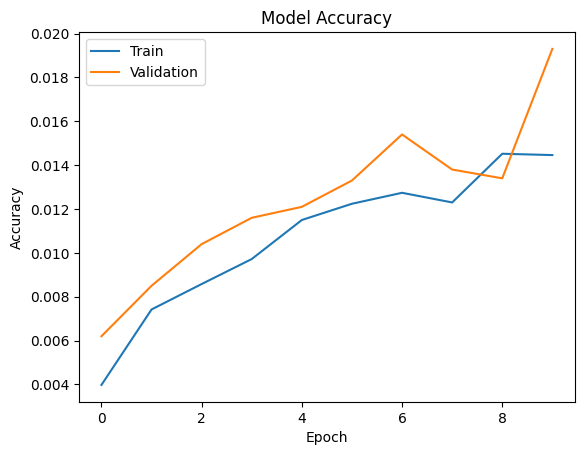

1/1 [==============================] - 0s 17ms/step


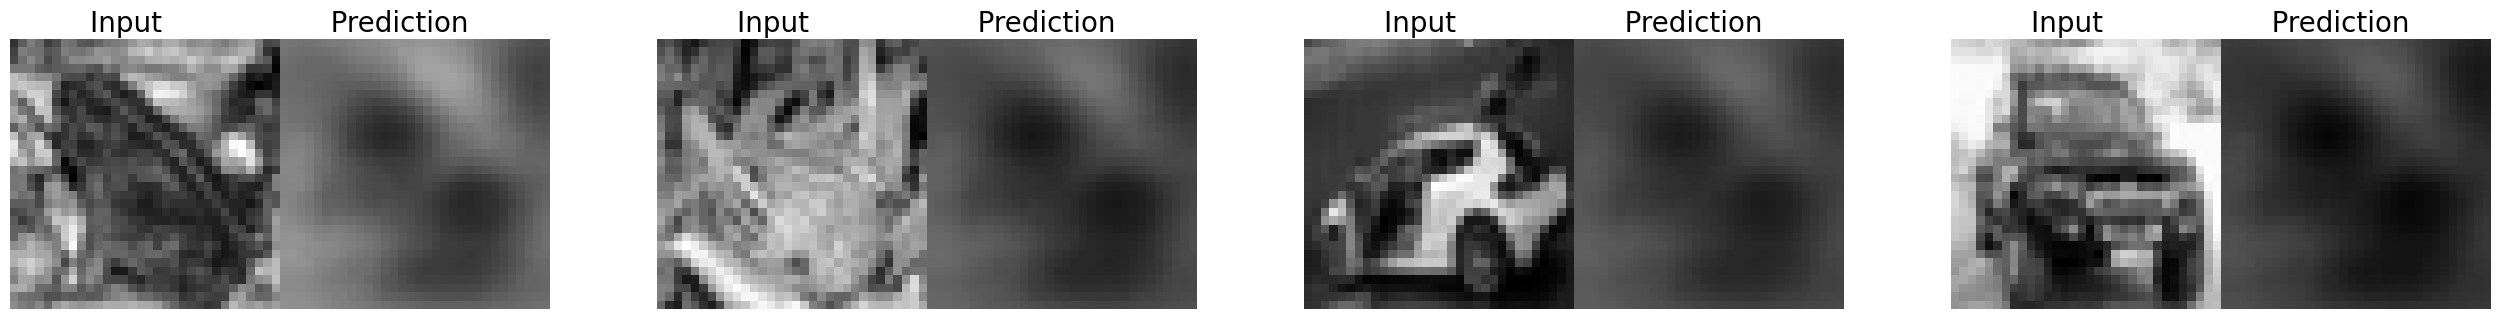

In [ ]:
#@title Simple Model Visualization

# Loss graph
plot_loss_graph(history)

# Accuracy Plot
plot_acc_graph(history)

f, axarr = plt.subplots(nrows=1, ncols=4, figsize=[32,32])
model_pred = model.predict(x_test_g[30,:].reshape(1,1024));
in1=x_test_g[30,:].reshape(1,1024)
model_input_image = in1.reshape(32,32)
model_pred_image = model_pred.reshape(32,32)
axarr[0].imshow(np.hstack((model_input_image,model_pred_image)), cmap='gray') # airplane 
model_pred = model.predict(x_test_g[30,:].reshape(1,1024));
in1=x_test_g[4,:].reshape(1,1024)
model_input_image = in1.reshape(32,32)
model_pred_image = model_pred.reshape(32,32)
axarr[1].imshow(np.hstack((model_input_image,model_pred_image)), cmap='gray') # automobile
model_pred = model.predict(x_test_g[30,:].reshape(1,1024));
in1=x_test_g[6,:].reshape(1,1024)
model_input_image = in1.reshape(32,32)
model_pred_image = model_pred.reshape(32,32)
axarr[2].imshow(np.hstack((model_input_image,model_pred_image)), cmap='gray')  # bird
model_pred = model.predict(x_test_g[30,:].reshape(1,1024));
in1=x_test_g[9,:].reshape(1,1024)
model_input_image = in1.reshape(32,32)
model_pred_image = model_pred.reshape(32,32)
axarr[3].imshow(np.hstack((model_input_image,model_pred_image)), cmap='gray')  # cat
for j in range(4):
  axarr[j].axis('off')
for t in range(4):
    axarr[t].set_title('Input                   Prediction', fontsize=20)

W1 Matrix shape:  (1024, 32)
W2 Matrix shape:  (32, 1024)


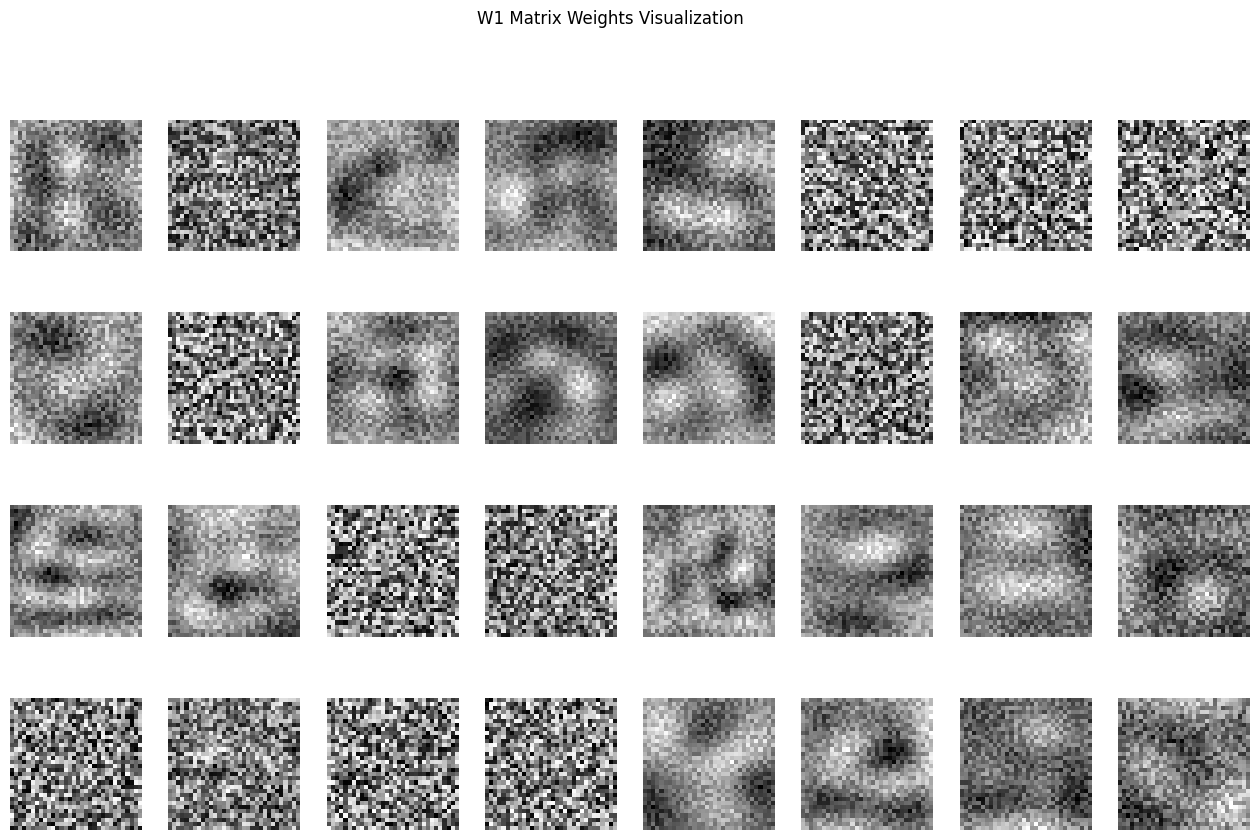

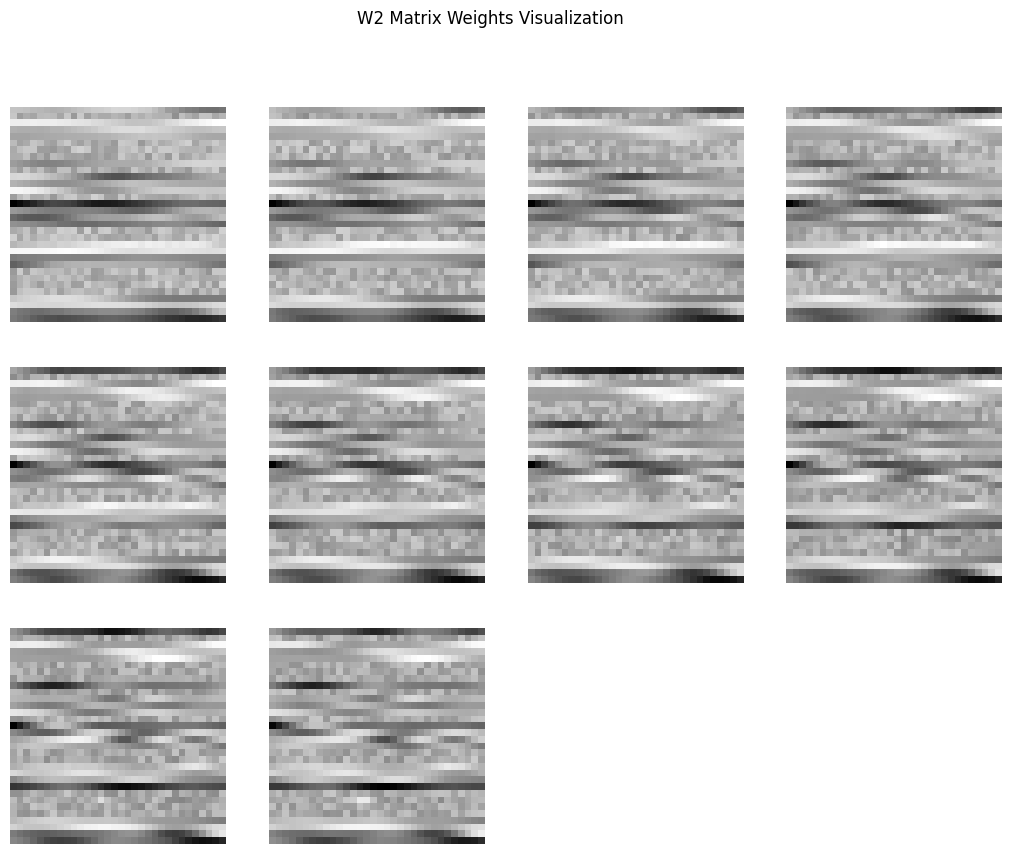

In [ ]:
#@title Weights Visualization
weights = model.get_weights()

# Weights Vizualization for first layer, W1 Matrix
print('W1 Matrix shape: ', weights[0].shape)
w1 = weights[0]
w1_reshaped = np.reshape(w1,[32,32,32])
fig = plt.figure(figsize=[16,9.6])
for i in range(32):
    weight_img = w1_reshaped[:,:,i]
    plt.suptitle('W1 Matrix Weights Visualization')
    plt.subplot(4, 8, i+1)
    plt.imshow(weight_img, cmap='gray', interpolation='none')
    plt.axis('off')

# Weights Visualisation of second layer, W2 Matrix 
print('W2 Matrix shape: ', weights[2].shape)
fig = plt.figure(figsize=[12.8,9.6])
w2 = weights[2]
w2_reshaped = np.reshape(w2,[32,32,32])
for i in range(10):
    weight_img = w2_reshaped[:,:,i]
    plt.suptitle('W2 Matrix Weights Visualization')
    plt.subplot(3, 4, i+1)
    plt.imshow(weight_img, cmap='gray', interpolation='none')
    plt.axis('off')

##Task 2:
Keeping the training and target values, develop and test five meaningfully different models. Try changing the size of the encoding layer, assorter hyperparameters, L1/L2 regularizers, and so on. Keep track of the final model losses in a neatly formatted table. Comment and store the models as needed since you will have to reuse them in Task 3.

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Compression (Dense)         (None, 512)               524800    
                                                                 
 Output (Dense)              (None, 1024)              525312    
                                                                 
Total params: 1,050,112
Trainable params: 1,050,112
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
391/391 [==============================] - 13s 33ms/step - loss: 0.6197 - accuracy: 0.0100 - val_loss: 0.5974 - val_accuracy: 0.0169
Epoch 2/100
391/391 [==============================] - 13s 33ms/step - loss: 0.5906 - accuracy: 0.0187 - val_loss: 0.5868 - val_accuracy: 0.0237
Epoch 3/100
391/391 [==============================] - 13s 33ms/step - loss: 0.5848 - accuracy: 0.0249 - val_loss: 0.5836 - val_accuracy: 0.0255
Epoch

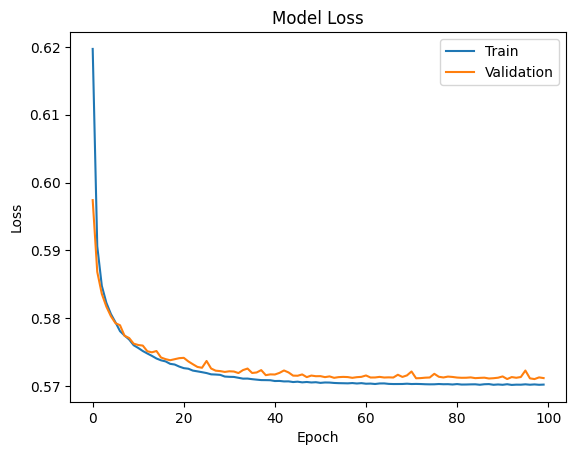

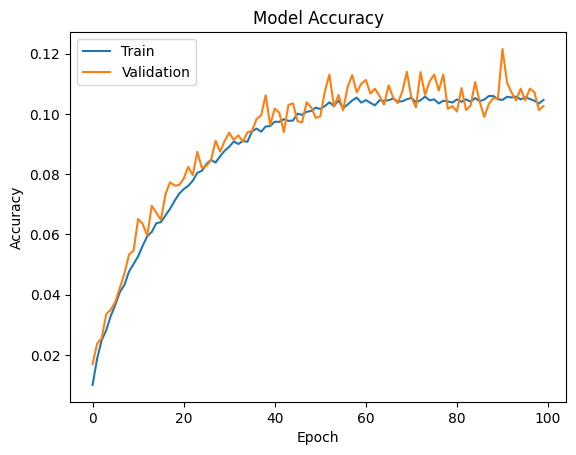

In [ ]:
#@title Model 1 -- Trained on Non-Noisy Images
bottleneck_size = 512
learning_rate = 0.1
hidden_activation = 'relu'
optimizer = 'adam'

model_1 = get_task2_model(bottleneck_size, hidden_activation, learning_rate, optimizer) 

training_samples = 50000
testing_samples  = 10000

batch_size = 128
epochs     = 100

history_1 = model_1.fit(x_train_g[:training_samples],  
                    x_train_g[:training_samples],
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=(x_test_g[:testing_samples],x_test_g[:testing_samples]))

plot_loss_graph(history_1) 
plot_acc_graph(history_1) 

filename = "history_1.pickle"
var_to_save = history_1      
with open(filename, 'wb') as handle:
    pickle.dump(var_to_save, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#@title Model 2 -- Trained on Non-Noisy Images

regularizer = regularizers.l1(0.0001)
bottleneck_size = 512
learning_rate = 0.1

hidden_activation = 'relu'
optimizer = 'adam'

model_2 = get_task2_model(bottleneck_size, hidden_activation, learning_rate, optimizer, regularizer) 

training_samples = 50000
testing_samples  = 10000

batch_size = 128
epochs     = 100

history_2 = model_2.fit(x_train_g[:training_samples],  
                    x_train_g[:training_samples],
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=(x_test_g[:testing_samples],x_test_g[:testing_samples]))

plot_loss_graph(history_2) 
plot_acc_graph(history_2) 

model_ID = 2 			
filename = f"history_{model_ID}.pickle"
var_to_save = history_2      
with open(filename, 'wb') as handle:
    pickle.dump(var_to_save, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#@title Model 3 -- Trained on Non-Noisy Images
regularizer = regularizers.l2(0.0001)
bottleneck_size = 512
learning_rate = 0.1

hidden_activation = 'relu'
optimizer = 'adam'

model_3 = get_task2_model(bottleneck_size, hidden_activation, learning_rate, optimizer, regularizer) 

training_samples = 50000
testing_samples  = 10000

batch_size = 128
epochs     = 100

history_3 = model_2.fit(x_train_g[:training_samples],  
                    x_train_g[:training_samples],
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=(x_test_g[:testing_samples],x_test_g[:testing_samples]))

plot_loss_graph(history_3) 
plot_acc_graph(history_3) 

model_ID = 3 			
filename = f"history_{model_ID}.pickle"
var_to_save = history_3      
with open(filename, 'wb') as handle:
    pickle.dump(var_to_save, handle, protocol=pickle.HIGHEST_PROTOCOL)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Compression (Dense)         (None, 512)               524800    
                                                                 
 Output (Dense)              (None, 1024)              525312    
                                                                 
Total params: 1,050,112
Trainable params: 1,050,112
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
391/391 [==============================] - 15s 37ms/step - loss: 0.6191 - accuracy: 0.0108 - val_loss: 0.5984 - val_accuracy: 0.0147
Epoch 2/100
391/391 [==============================] - 23s 58ms/step - loss: 0.5917 - accuracy: 0.0179 - val_loss: 0.5878 - val_accuracy: 0.0208
Epoch 3/100
391/391 [==============================] - 14s 36ms/step - loss: 0.5853 - accuracy: 0.0245 - val_loss: 0.5861 - val_accuracy: 0.0284
Epoch

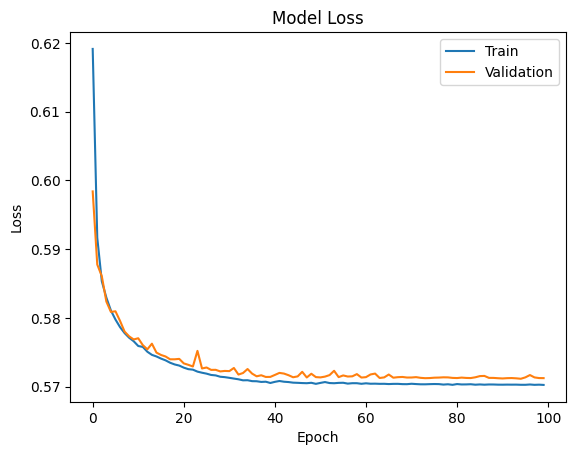

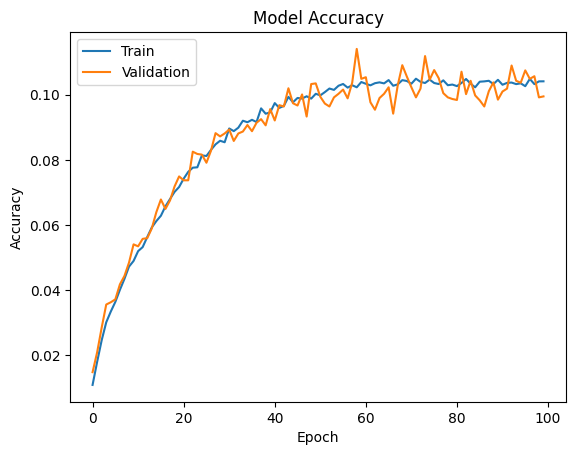

In [ ]:
#@title Model 4 -- Trained on Non-Noisy Images
bottleneck_size = 512
learning_rate = 0.01
# No regularizer
hidden_activation = 'relu'
optimizer = 'adam'

model_4 = get_task2_model(bottleneck_size, hidden_activation, learning_rate, optimizer) 

training_samples = 50000
testing_samples  = 10000

batch_size = 128
epochs     = 100

history_4 = model_4.fit(x_train_g[:training_samples],  
                    x_train_g[:training_samples],
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=(x_test_g[:testing_samples],x_test_g[:testing_samples]))

plot_loss_graph(history_4) 
plot_acc_graph(history_4) 

model_ID = 4 			
filename = f"history_{model_ID}.pickle"
var_to_save = history_4      
with open(filename, 'wb') as handle:
    pickle.dump(var_to_save, handle, protocol=pickle.HIGHEST_PROTOCOL)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Compression (Dense)         (None, 256)               262400    
                                                                 
 Output (Dense)              (None, 1024)              263168    
                                                                 
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
391/391 [==============================] - 8s 19ms/step - loss: 0.6250 - accuracy: 0.0092 - val_loss: 0.6032 - val_accuracy: 0.0145
Epoch 2/100
391/391 [==============================] - 8s 20ms/step - loss: 0.5952 - accuracy: 0.0146 - val_loss: 0.5910 - val_accuracy: 0.0169
Epoch 3/100
391/391 [==============================] - 8s 19ms/step - loss: 0.5882 - accuracy: 0.0188 - val_loss: 0.5873 - val_accuracy: 0.0171
Epoch 4/100


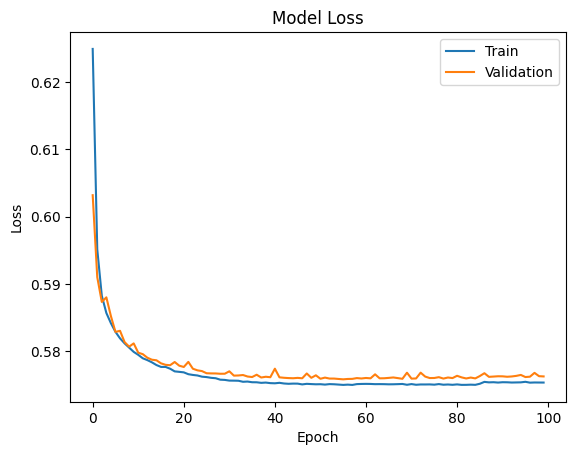

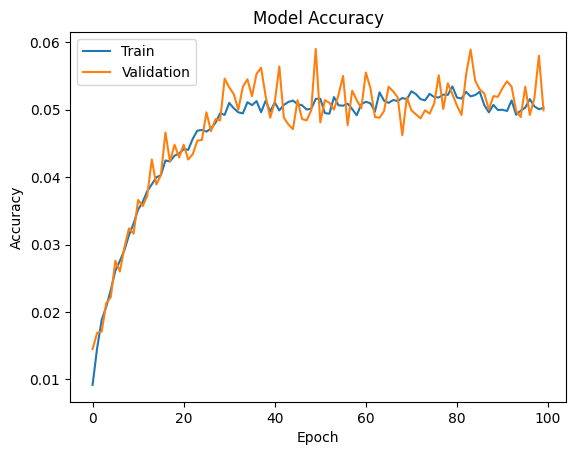

In [ ]:
#@title Model 5 -- Trained on Non-Noisy Images
bottleneck_size = 256
learning_rate = 0.1
# No regularizer
hidden_activation = 'relu'
optimizer = 'adam'


model_5 = get_task2_model(bottleneck_size, hidden_activation, learning_rate, optimizer) 

training_samples = 50000
testing_samples  = 10000

batch_size = 128
epochs     = 100

history_5 = model_5.fit(x_train_g[:training_samples],  
                    x_train_g[:training_samples],
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=(x_test_g[:testing_samples],x_test_g[:testing_samples]))

plot_loss_graph(history_5) 
plot_acc_graph(history_5) 

model_ID = 5 			
filename = f"history_{model_ID}.pickle"
var_to_save = history_5      
with open(filename, 'wb') as handle:
    pickle.dump(var_to_save, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#@title Load in Pickle Files for Each Model

trained_models_list = [] #put all models in the list
for i in range(1,6):
  filename = f"history_{i}.pickle"
  with open(filename, 'rb') as handle:
    history = pickle.load(handle)
    trained_models_list.append(history)
models_dict = {i:history for i, history in enumerate(trained_models_list)}


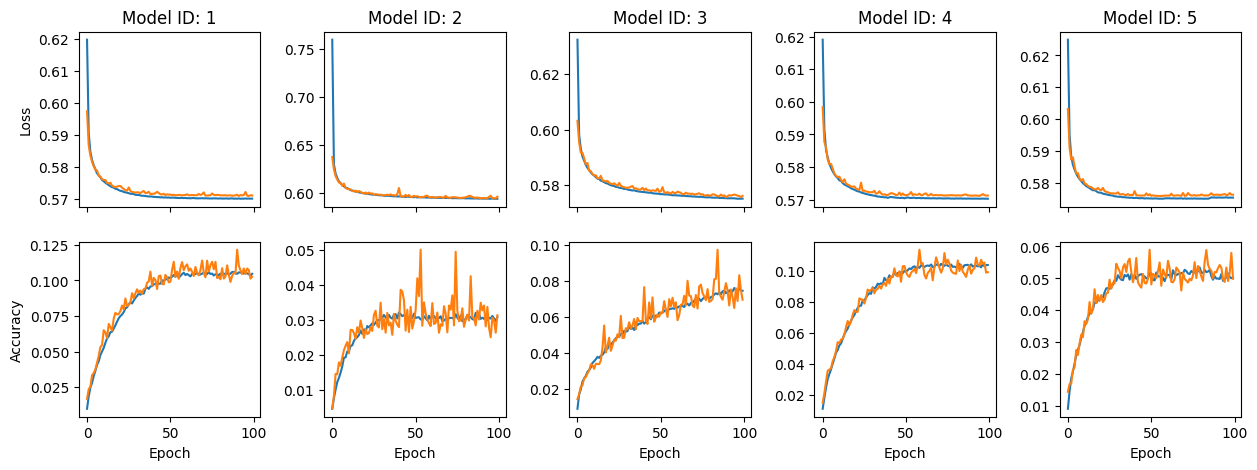

In [ ]:
#@title Loss and Accuracy Curves
fig, axs = plt.subplots(2,5, figsize = (15,5), sharex = True)

axs = axs.flatten()

for id, history in models_dict.items():
  ax1_id  = id
  ax2_id  = ax1_id + 5

  ax = axs[ax1_id]
  ax2 = axs[ax2_id]

  ax.set_title(f"Model ID: {ax1_id+1}")
  ax.plot(history.history["loss"], label = "Train")
  ax.plot(history.history["val_loss"], label = "Validation")
  if id == 0:

    ax.set_ylabel("Loss")
    ax2.set_ylabel("Accuracy")
  
  ax2.plot(history.history["accuracy"], label = "Train")
  ax2.plot(history.history["val_accuracy"], label = "Validation")
  ax2.set_xlabel("Epoch")
plt.subplots_adjust(wspace = 0.35)


1/1 [==============================] - 0s 31ms/step


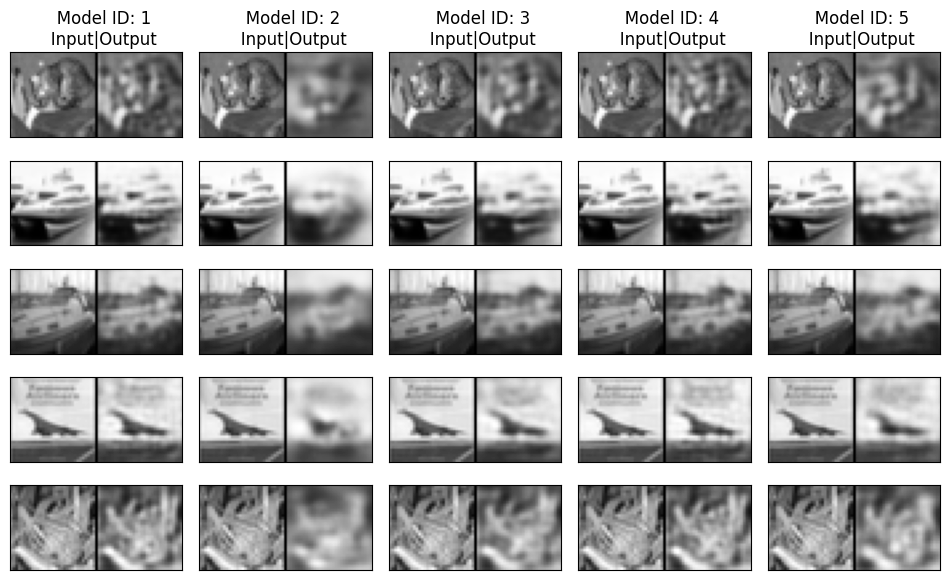

In [ ]:
#@title Reconstruction of Non-Noisy Images

n_images_per_model = 5
fig, axs = plt.subplots(n_images_per_model,5, figsize = (12,7))

for col, history in models_dict.items():
  model =  history.model
  for i in range(n_images_per_model):
    ax = axs[i,col]
    
    model_pred = model.predict(x_test_g[i,:].reshape(1,1024))
    in1        = x_test_g[i,:].reshape(1,1024)

    model_input_image = in1.reshape(32,32)
    model_pred_image  = model_pred.reshape(32,32)

    ax.imshow(np.hstack((model_input_image,np.zeros(shape=(model_input_image.shape[0],1)) ,model_pred_image)), cmap='gray')
    
    ax.set_xticks([])
    ax.set_yticks([])
    if i == 0:
      ax.set_title(f"   Model ID: {col+1}\n   Input|Output")
plt.subplots_adjust(wspace = 0.1, hspace = 0.02)

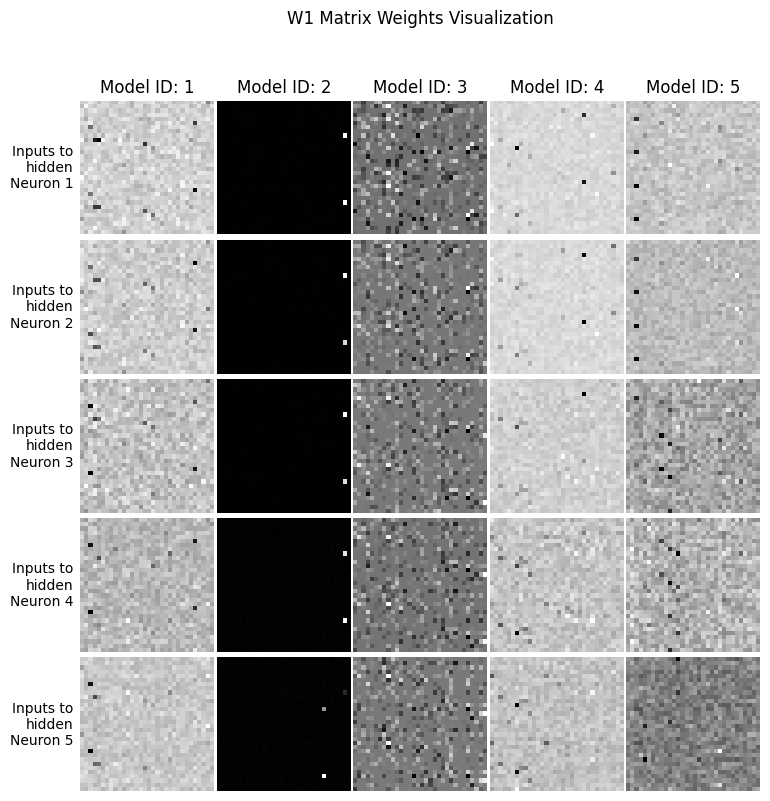

In [ ]:
#@title Weights Visualization First Layer
n_weights_per_model = 5
fig, axs = plt.subplots(n_weights_per_model,5, figsize=[17,9])



for model_ID in range(5):
  model = models_dict[model_ID].model

  weights = model.get_weights()

  # Weights Vizualization for first layer, W1 Matrix
  # print('W1 Matrix shape: ', weights[0].shape)

  w1 = weights[0]
  w1_reshaped = np.reshape(w1,[-1,32,32])


  for i in range(n_weights_per_model):
      ax = axs[i,model_ID]
      weight_img = w1_reshaped[i,:,:]
      fig.suptitle('W1 Matrix Weights Visualization')
      
      # ax.subplot(n_weights_per_model, 5, i+1)
      ax.imshow(weight_img, cmap='gray', interpolation='none')
      ax.axis('off')
      if i == 0:
        ax.set_title(f"Model ID: {model_ID+1}")
      if model_ID == 0:
        ax.annotate(f"Inputs to\nhidden\nNeuron {i+1}", xy = (-0.05, 0.5), xycoords = "axes fraction", ha = "right", va = "center")
plt.subplots_adjust(wspace = 0.02, hspace = 0.02, left = 0.3, right = 0.7)


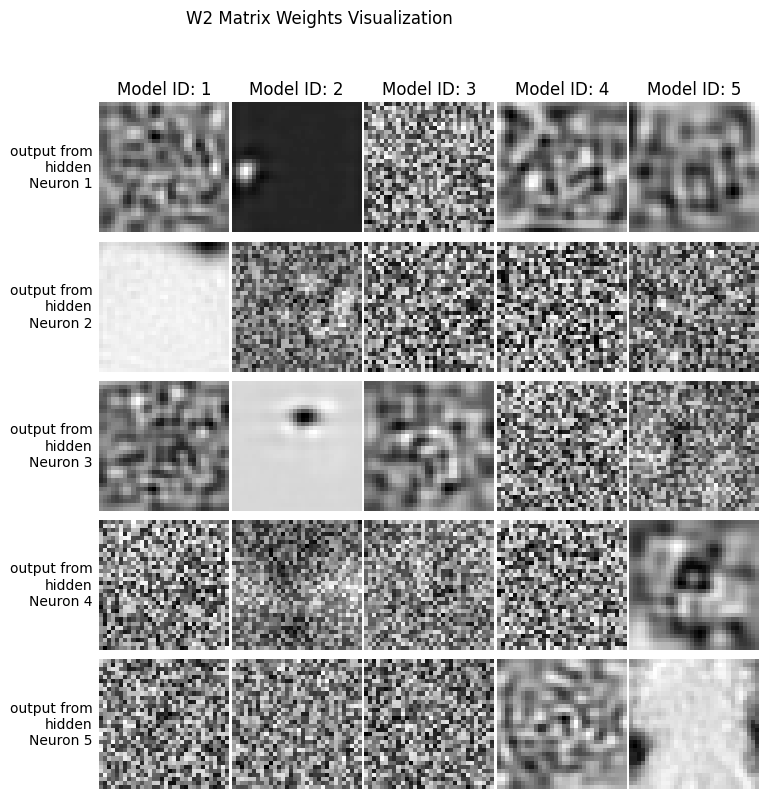

In [ ]:
#@title Weights Visualization Second layer
n_weights_per_model = 5
fig, axs = plt.subplots(n_weights_per_model,5, figsize=[11,9])



for model_ID in range(5):
  model = models_dict[model_ID].model


  weights = model.get_weights()

  # Weights Vizualization for first layer, W1 Matrix
  # print('W2 Matrix shape: ', weights[2].shape)

  w2 = weights[2]
  w2_reshaped = np.reshape(w2,[-1,32,32])


  for i in range(n_weights_per_model):
      ax = axs[i,model_ID]
      weight_img = w2_reshaped[i,:,:]
      fig.suptitle('W2 Matrix Weights Visualization')
      
      # ax.subplot(n_weights_per_model, 5, i+1)
      ax.imshow(weight_img, cmap='gray', interpolation='none')
      ax.axis('off')
      if i == 0:
        ax.set_title(f"Model ID: {model_ID+1}")
      if model_ID == 0:
        ax.annotate(f"output from\nhidden\nNeuron {i+1}", xy = (-0.05, 0.5), xycoords = "axes fraction", ha = "right", va = "center")
plt.subplots_adjust(wspace = 0.02, hspace = 0.02, left = 0.3)

##Task 3:
Produce a set of noisy CIFAR images. Keep the amplitude fo the additive noise fairly small compared to the noise amplitude in Lab 3 Intro (between 0.05 and 0.1). Use the input data to the noisy images and keep the target as the non-noisy images. Retrain the five models with the new input of noisy CIFAR images. How does the loss compare to the original runs in Task 2? How well does your "best performing" AE model actually denoise the image?

In [ ]:
x_train_g     = x_train_g.reshape(50000, 1024)
x_test_g      = x_test_g.reshape(10000, 1024)
x_train_noisy = x_train_noisy.reshape(50000, 1024)
x_test_noisy  = x_test_noisy.reshape(10000, 1024)

training_samples = 50000
testing_samples  = 10000
batch_size = 128
epochs     = 100

Epoch 1/100
391/391 [==============================] - 17s 41ms/step - loss: 0.5717 - accuracy: 0.0892 - val_loss: 0.5729 - val_accuracy: 0.0884
Epoch 2/100
391/391 [==============================] - 14s 37ms/step - loss: 0.5717 - accuracy: 0.0879 - val_loss: 0.5728 - val_accuracy: 0.0875
Epoch 3/100
391/391 [==============================] - 15s 38ms/step - loss: 0.5716 - accuracy: 0.0874 - val_loss: 0.5731 - val_accuracy: 0.0862
Epoch 4/100
391/391 [==============================] - 15s 38ms/step - loss: 0.5716 - accuracy: 0.0877 - val_loss: 0.5727 - val_accuracy: 0.0836
Epoch 5/100
391/391 [==============================] - 14s 37ms/step - loss: 0.5716 - accuracy: 0.0867 - val_loss: 0.5727 - val_accuracy: 0.0856
Epoch 6/100
391/391 [==============================] - 20s 51ms/step - loss: 0.5716 - accuracy: 0.0875 - val_loss: 0.5725 - val_accuracy: 0.0860
Epoch 7/100
391/391 [==============================] - 20s 51ms/step - loss: 0.5715 - accuracy: 0.0879 - val_loss: 0.5727 - val_ac

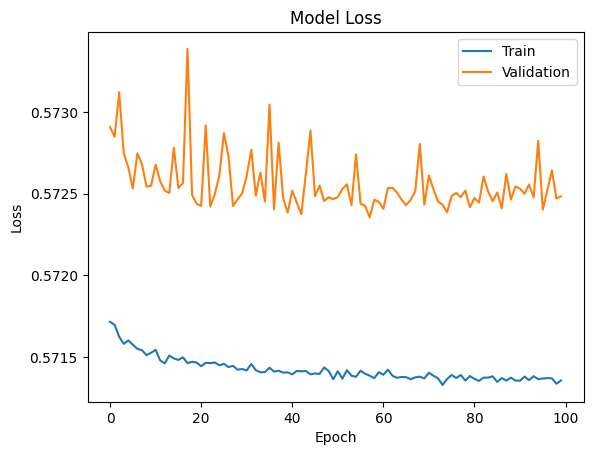

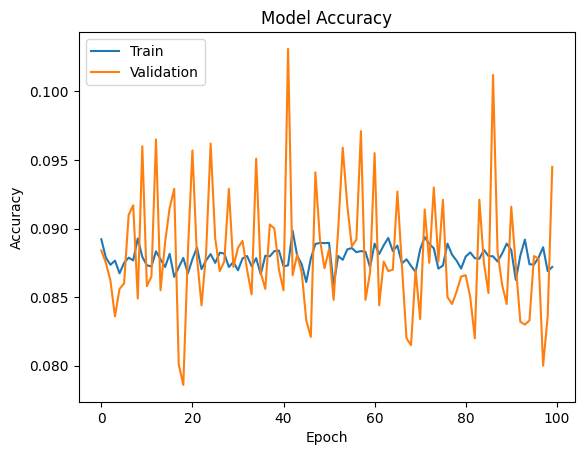

In [ ]:
#@title Model 1  -- Re-trained on Noisy Images
model_1_noisy = models_dict[0].model
history_1 = model_1_noisy.fit(x_train_noisy[:training_samples],  
                    x_train_g[:training_samples],
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=(x_test_noisy[:testing_samples],x_test_g[:testing_samples]))

plot_loss_graph(history_1) 
plot_acc_graph(history_1) 

filename = "history_1_retrain.pickle"
var_to_save = history_1      
with open(filename, 'wb') as handle:
    pickle.dump(var_to_save, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/100
391/391 [==============================] - 16s 39ms/step - loss: 0.5951 - accuracy: 0.0283 - val_loss: 0.5957 - val_accuracy: 0.0275
Epoch 2/100
391/391 [==============================] - 15s 40ms/step - loss: 0.5948 - accuracy: 0.0280 - val_loss: 0.5977 - val_accuracy: 0.0273
Epoch 3/100
391/391 [==============================] - 15s 38ms/step - loss: 0.5948 - accuracy: 0.0290 - val_loss: 0.5960 - val_accuracy: 0.0296
Epoch 4/100
391/391 [==============================] - 16s 40ms/step - loss: 0.5949 - accuracy: 0.0282 - val_loss: 0.5952 - val_accuracy: 0.0367
Epoch 5/100
391/391 [==============================] - 15s 38ms/step - loss: 0.5950 - accuracy: 0.0298 - val_loss: 0.5955 - val_accuracy: 0.0279
Epoch 6/100
391/391 [==============================] - 15s 39ms/step - loss: 0.5948 - accuracy: 0.0277 - val_loss: 0.5959 - val_accuracy: 0.0252
Epoch 7/100
391/391 [==============================] - 15s 39ms/step - loss: 0.5948 - accuracy: 0.0294 - val_loss: 0.5956 - val_ac

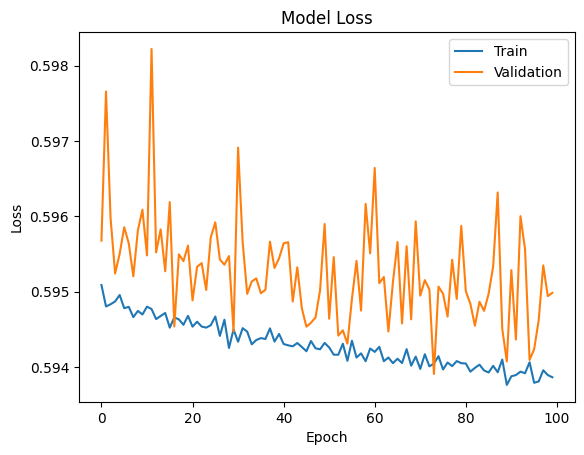

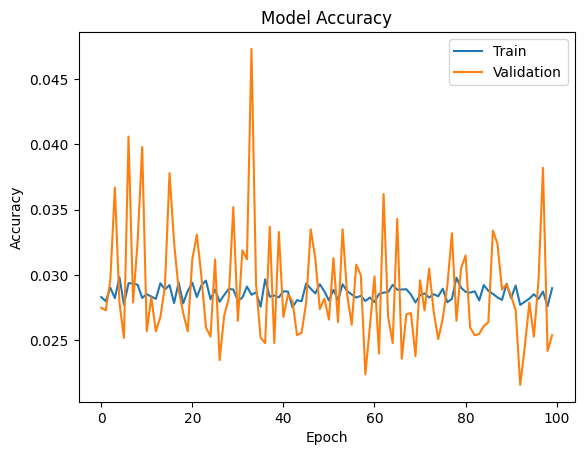

In [ ]:
#@title Model 2  -- Re-trained on Noisy Images
model_2_noisy = models_dict[1].model
history_2 = model_2_noisy.fit(x_train_noisy[:training_samples],  
                    x_train_g[:training_samples],
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=(x_test_noisy[:testing_samples],x_test_g[:testing_samples]))

plot_loss_graph(history_2) 
plot_acc_graph(history_2) 

filename = "history_2_retrain.pickle"
var_to_save = history_2      
with open(filename, 'wb') as handle:
    pickle.dump(var_to_save, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/100
391/391 [==============================] - 20s 50ms/step - loss: 0.5761 - accuracy: 0.0671 - val_loss: 0.5769 - val_accuracy: 0.0709
Epoch 2/100
391/391 [==============================] - 17s 44ms/step - loss: 0.5760 - accuracy: 0.0654 - val_loss: 0.5767 - val_accuracy: 0.0743
Epoch 3/100
391/391 [==============================] - 18s 47ms/step - loss: 0.5759 - accuracy: 0.0678 - val_loss: 0.5776 - val_accuracy: 0.0699
Epoch 4/100
391/391 [==============================] - 14s 37ms/step - loss: 0.5759 - accuracy: 0.0667 - val_loss: 0.5769 - val_accuracy: 0.0678
Epoch 5/100
391/391 [==============================] - 14s 37ms/step - loss: 0.5759 - accuracy: 0.0665 - val_loss: 0.5773 - val_accuracy: 0.0607
Epoch 6/100
391/391 [==============================] - 15s 37ms/step - loss: 0.5758 - accuracy: 0.0670 - val_loss: 0.5768 - val_accuracy: 0.0646
Epoch 7/100
391/391 [==============================] - 14s 37ms/step - loss: 0.5759 - accuracy: 0.0663 - val_loss: 0.5766 - val_ac

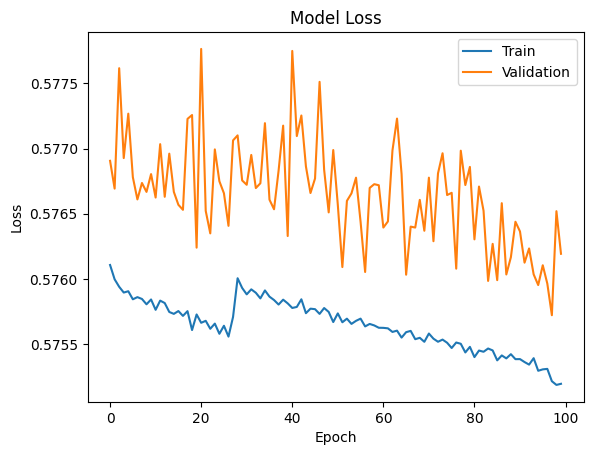

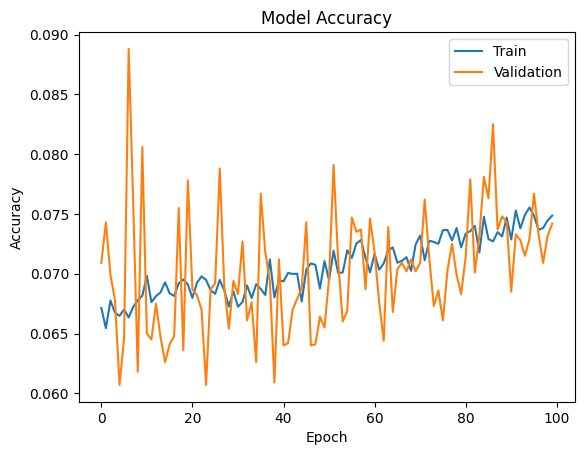

In [ ]:
#@title Model 3  -- Re-trained on Noisy Images
model_3_noisy = models_dict[2].model
history_3 = model_3_noisy.fit(x_train_noisy[:training_samples],  
                    x_train_g[:training_samples],
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=(x_test_noisy[:testing_samples],x_test_g[:testing_samples]))

plot_loss_graph(history_3) 
plot_acc_graph(history_3) 

filename = "history_3_retrain.pickle"
var_to_save = history_3      
with open(filename, 'wb') as handle:
    pickle.dump(var_to_save, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/100
391/391 [==============================] - 15s 37ms/step - loss: 0.5718 - accuracy: 0.0867 - val_loss: 0.5728 - val_accuracy: 0.0894
Epoch 2/100
391/391 [==============================] - 14s 36ms/step - loss: 0.5717 - accuracy: 0.0873 - val_loss: 0.5728 - val_accuracy: 0.0874
Epoch 3/100
391/391 [==============================] - 14s 36ms/step - loss: 0.5717 - accuracy: 0.0876 - val_loss: 0.5726 - val_accuracy: 0.0877
Epoch 4/100
391/391 [==============================] - 14s 36ms/step - loss: 0.5716 - accuracy: 0.0861 - val_loss: 0.5726 - val_accuracy: 0.0842
Epoch 5/100
391/391 [==============================] - 14s 36ms/step - loss: 0.5717 - accuracy: 0.0868 - val_loss: 0.5729 - val_accuracy: 0.0894
Epoch 6/100
391/391 [==============================] - 14s 36ms/step - loss: 0.5716 - accuracy: 0.0863 - val_loss: 0.5725 - val_accuracy: 0.0907
Epoch 7/100
391/391 [==============================] - 14s 36ms/step - loss: 0.5716 - accuracy: 0.0863 - val_loss: 0.5729 - val_ac

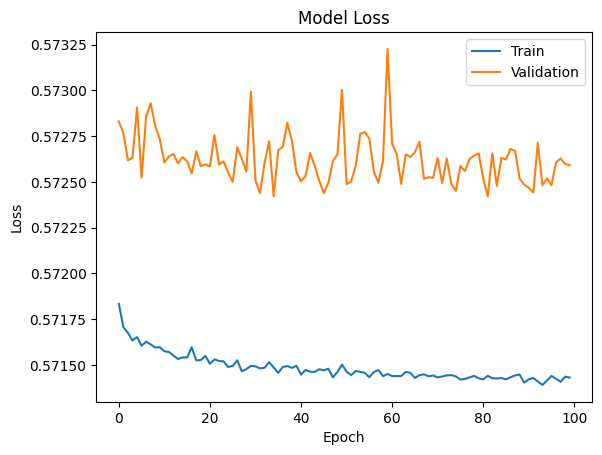

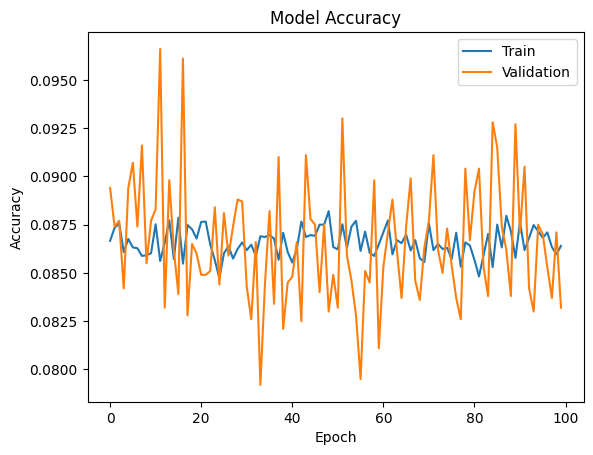

In [ ]:
#@title Model 4  -- Re-trained on Noisy Images
model_4_noisy = models_dict[3].model
history_4 = model_4_noisy.fit(x_train_noisy[:training_samples],  
                    x_train_g[:training_samples],
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=(x_test_noisy[:testing_samples],x_test_g[:testing_samples]))

plot_loss_graph(history_4) 
plot_acc_graph(history_4) 

filename = "history_4_retrain.pickle"
var_to_save = history_4      
with open(filename, 'wb') as handle:
    pickle.dump(var_to_save, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/100
391/391 [==============================] - 11s 26ms/step - loss: 0.5763 - accuracy: 0.0460 - val_loss: 0.5771 - val_accuracy: 0.0458
Epoch 2/100
391/391 [==============================] - 8s 20ms/step - loss: 0.5763 - accuracy: 0.0465 - val_loss: 0.5775 - val_accuracy: 0.0451
Epoch 3/100
391/391 [==============================] - 10s 25ms/step - loss: 0.5763 - accuracy: 0.0457 - val_loss: 0.5772 - val_accuracy: 0.0497
Epoch 4/100
391/391 [==============================] - 9s 24ms/step - loss: 0.5762 - accuracy: 0.0463 - val_loss: 0.5772 - val_accuracy: 0.0452
Epoch 5/100
391/391 [==============================] - 8s 20ms/step - loss: 0.5763 - accuracy: 0.0456 - val_loss: 0.5771 - val_accuracy: 0.0491
Epoch 6/100
391/391 [==============================] - 9s 24ms/step - loss: 0.5762 - accuracy: 0.0462 - val_loss: 0.5773 - val_accuracy: 0.0453
Epoch 7/100
391/391 [==============================] - 8s 21ms/step - loss: 0.5763 - accuracy: 0.0463 - val_loss: 0.5771 - val_accurac

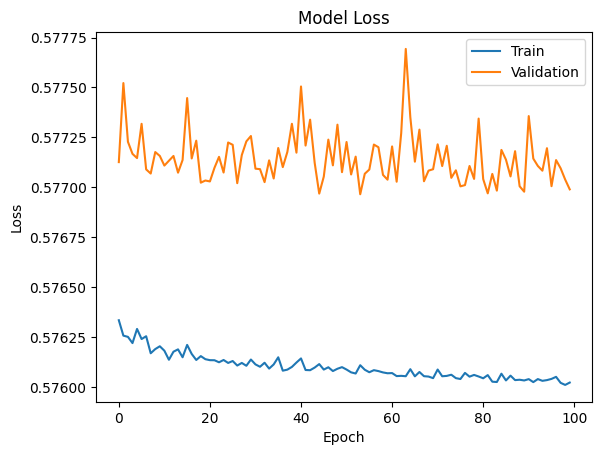

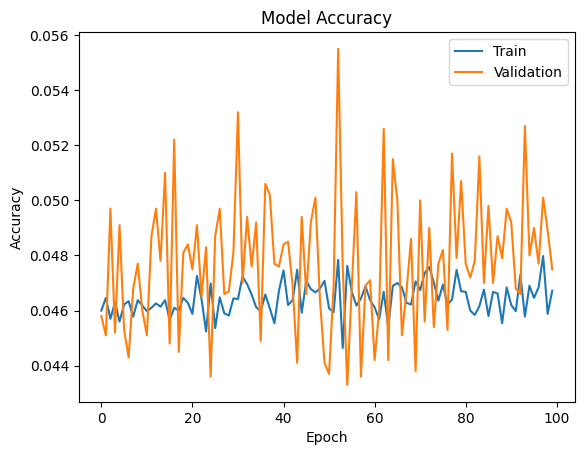

In [ ]:
#@title Model 5  -- Re-trained on Noisy Images
model_5_noisy = models_dict[4].model
history_5 = model_5_noisy.fit(x_train_noisy[:training_samples],  
                    x_train_g[:training_samples],
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=(x_test_noisy[:testing_samples],x_test_g[:testing_samples]))

plot_loss_graph(history_5) 
plot_acc_graph(history_5) 

filename = "history_5_retrain.pickle"
var_to_save = history_5      
with open(filename, 'wb') as handle:
    pickle.dump(var_to_save, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#@title Load in Pickle Files for Each Model
os.chdir("/content/")
trained_models_list = [] #put all models in the list
for i in range(1,6):
  filename = f"history_{i}_retrain.pickle"
  with open(filename, 'rb') as handle:
    history = pickle.load(handle)
    trained_models_list.append(history)
models_dict = {i:history for i, history in enumerate(trained_models_list)}

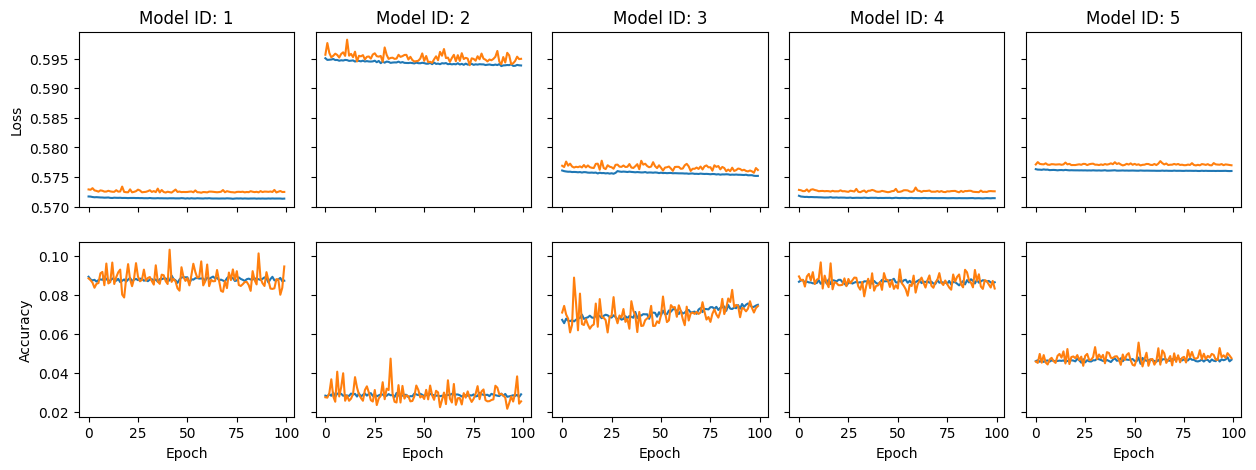

In [ ]:
#@title Loss and Accuracy Curves
fig, axs = plt.subplots(2,5, figsize = (15,5), sharex = True, sharey = "row")

axs = axs.flatten()

for id, history in models_dict.items():
  ax1_id  = id
  ax2_id  = ax1_id + 5

  ax = axs[ax1_id]
  ax2 = axs[ax2_id]

  ax.set_title(f"Model ID: {ax1_id+1}")
  ax.plot(history.history["loss"], label = "Train")
  ax.plot(history.history["val_loss"], label = "Validation")
  if id == 0:

    ax.set_ylabel("Loss")
    ax2.set_ylabel("Accuracy")
  
  ax2.plot(history.history["accuracy"], label = "Train")
  ax2.plot(history.history["val_accuracy"], label = "Validation")
  ax2.set_xlabel("Epoch")
plt.subplots_adjust(wspace = 0.1)

1/1 [==============================] - 0s 23ms/step


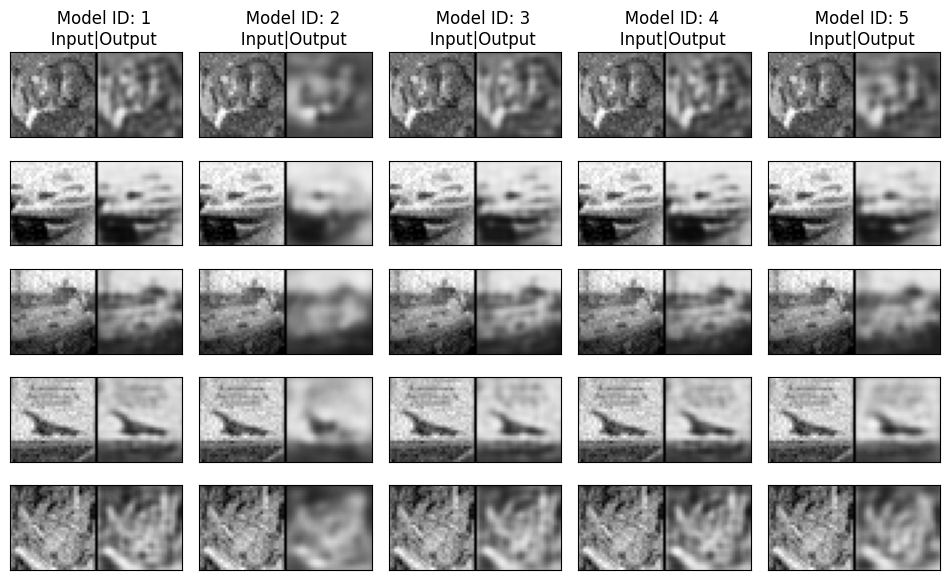

In [ ]:
#@title Reconstruction of Noisy Images

n_images_per_model = 5
fig, axs = plt.subplots(n_images_per_model,5, figsize = (12,7))


for col, history in models_dict.items():
  model =  history.model
  for i in range(n_images_per_model):
    ax = axs[i,col]
    
    model_pred = model.predict(x_test_noisy[i,:].reshape(1,1024))
    in1        = x_test_noisy[i,:].reshape(1,1024)

    model_input_image = in1.reshape(32,32)
    model_pred_image  = model_pred.reshape(32,32)


    ax.imshow(np.hstack((model_input_image,np.zeros(shape=(model_input_image.shape[0],1)) ,model_pred_image)), cmap='gray')
    
    ax.set_xticks([])
    ax.set_yticks([])
    if i == 0:
      ax.set_title(f"   Model ID: {col+1}\n   Input|Output")
plt.subplots_adjust(wspace = 0.1, hspace = 0.02)

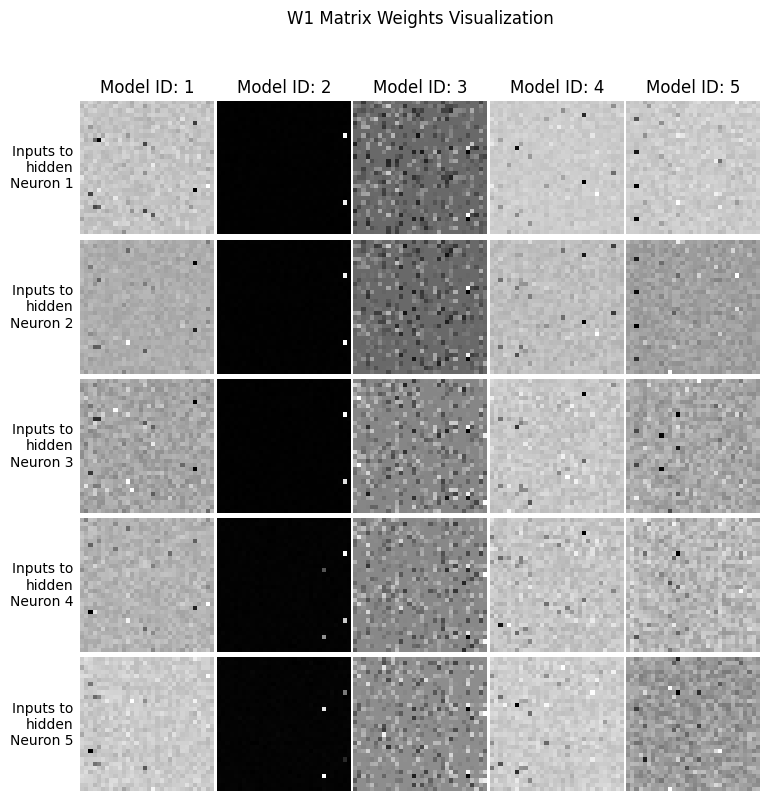

In [ ]:
#@title Weights Visualization first layer
n_weights_per_model = 5
fig, axs = plt.subplots(n_weights_per_model,5, figsize=[17,9])

for model_ID in range(5):
  model = models_dict[model_ID].model

  weights = model.get_weights()

  # Weights Vizualization for first layer, W1 Matrix
  # print('W1 Matrix shape: ', weights[0].shape)

  w1 = weights[0]
  w1_reshaped = np.reshape(w1,[-1,32,32])


  for i in range(n_weights_per_model):
      ax = axs[i,model_ID]
      weight_img = w1_reshaped[i,:,:]
      fig.suptitle('W1 Matrix Weights Visualization')
      
      # ax.subplot(n_weights_per_model, 5, i+1)
      ax.imshow(weight_img, cmap='gray', interpolation='none')
      ax.axis('off')
      if i == 0:
        ax.set_title(f"Model ID: {model_ID+1}")
      if model_ID == 0:
        ax.annotate(f"Inputs to\nhidden\nNeuron {i+1}", xy = (-0.05, 0.5), xycoords = "axes fraction", ha = "right", va = "center")
plt.subplots_adjust(wspace = 0.02, hspace = 0.02, left = 0.3, right = 0.7)

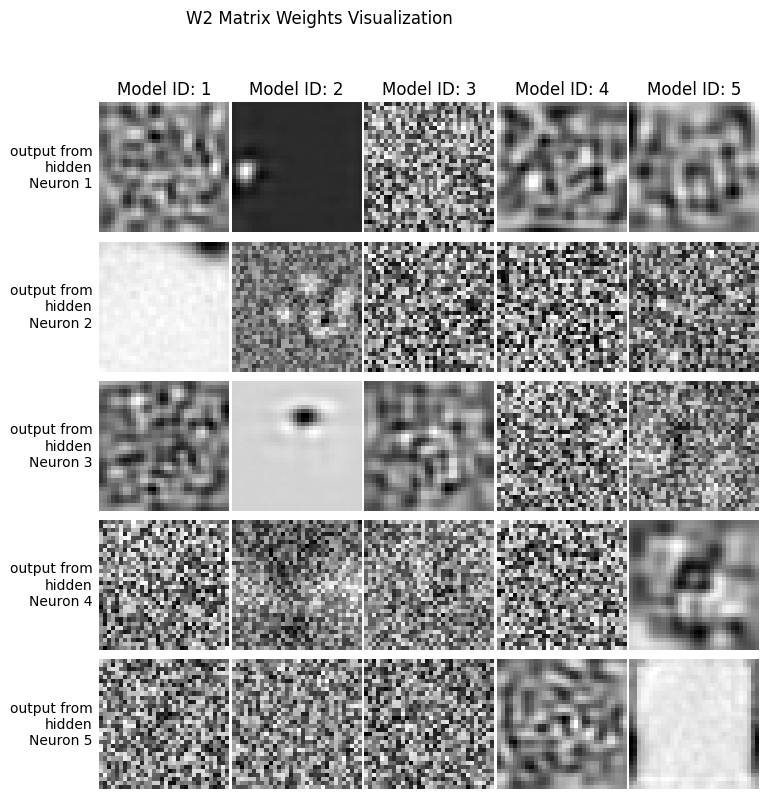

In [ ]:
#@title Weights Visualization Second layer
n_weights_per_model = 5
fig, axs = plt.subplots(n_weights_per_model,5, figsize=[11,9])



for model_ID in range(5):
  model = models_dict[model_ID].model


  weights = model.get_weights()

  # Weights Vizualization for first layer, W1 Matrix
  # print('W2 Matrix shape: ', weights[2].shape)

  w2 = weights[2]
  w2_reshaped = np.reshape(w2,[-1,32,32])


  for i in range(n_weights_per_model):
      ax = axs[i,model_ID]
      weight_img = w2_reshaped[i,:,:]
      fig.suptitle('W2 Matrix Weights Visualization')
      
      # ax.subplot(n_weights_per_model, 5, i+1)
      ax.imshow(weight_img, cmap='gray', interpolation='none')
      ax.axis('off')
      if i == 0:
        ax.set_title(f"Model ID: {model_ID+1}")
      if model_ID == 0:
        ax.annotate(f"output from\nhidden\nNeuron {i+1}", xy = (-0.05, 0.5), xycoords = "axes fraction", ha = "right", va = "center")
plt.subplots_adjust(wspace = 0.02, hspace = 0.02, left = 0.3)